In [95]:
def fisher(x):
    vals =[x[0], x[1],x[2],x[3]]
    #print(vals)
    o,p = ss.fisher_exact([[vals[0],vals[1]],[vals[2],vals[3]]])
    return o,p

def plotmotifenrichmentatTF(TF):
    print(TF)
    transfacts = [x for x in os.listdir(TFs) if TF in x][0]  #
    mytf = TFs+transfacts  

    #get all overlaps
    cmd = "bedtools intersect -a all_analyzed_strs.tab -b %s > Intersect.bed"%mytf
    returned_value = os.system(cmd)
    Inter = pd.read_csv('Intersect.bed', sep='\t', header=None, names=["chrom","start","end","gene"])
    Feature_strs = list(set(Inter.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1)))
    #Look at eSTRs overlaps 
    all_strs = pd.read_csv(REGRSSION, sep='\t')
    all_strs = all_strs[np.isfinite(all_strs['str.start'])] #Just in case we have NA here. shouldn't
    all_strs['str.start']=all_strs['str.start'].astype(int)
    all_strs['loci'] = all_strs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)
    data = all_strs.loc[all_strs['loci'].isin(Feature_strs)].copy()
    #Causal
    merged = pd.read_csv(MERGEFILE, sep="\t")
    merged['str.start'] = merged['best.str.start']
    merged = merged[np.isfinite(merged['str.start'])]; merged['str.start'] = merged['str.start'].astype(int) 
    merged['loci'] = merged["chrom"]+":"+merged["str.start"].astype(str)
    merged['causal'] = merged['top.variant'].apply(lambda x: 1 if "STR" in x else 0)
    #######
    A = data[["loci","gene","chrom","str.start","E.tissues","motif", "period"]]       #all strs at tfs
    B = merged[["gene", "loci","causal","top.variant","best.tissue", "NumTissues"]]   #all strs and causal score
    C = pd.merge(A,B, on=["gene","loci" ],how='left')                                 #merge for causal scores
    D = C.copy()                  #                                                   #get overlaps with TFs
    #######
    motifs = list(set(list(D["motif"])))
    cont_table = pd.DataFrame({"motifs":motifs, "total.count":[list(D["motif"]).count(x) for x in motifs] })
    #print(A.shape, B.shape, C.shape, D,shape,cont_table.shape, motifs)
    ##Fisher
    #estr enrichment
    estr = D.loc[D['E.tissues']>=1]
    cont_table["estr.count"] = [ list(estr['motif']).count(x) for x in motifs  ]
    cont_table["enonmotif"] = -cont_table["estr.count"]+estr.shape[0]
    cont_table["nonemotif"] = cont_table['total.count']-cont_table["estr.count"]
    cont_table["none.nonm"] = D.shape[0] - estr.shape[0]-cont_table["nonemotif"]
    cont_table['e.fisher'] = cont_table[["estr.count","enonmotif","nonemotif","none.nonm"]].apply(lambda x: fisher(x),1)
    cont_table["estr.odd"] = cont_table['e.fisher'].apply(lambda x: x[0])
    cont_table["estr.pval"] = cont_table['e.fisher'].apply(lambda x: -np.log10(x[1]))

    #Causal enrichment
    causal = estr.loc[estr["causal"]==1 ]
    cont_table["causal.count"] = [list(causal["motif"]).count(x) for x in motifs]
    cont_table["Cnonmotif"] = -cont_table["causal.count"]+estr.shape[0]
    cont_table["nonCmotif"] = cont_table['total.count']-cont_table["causal.count"]
    cont_table["nonC.nonm"] = D.shape[0] - causal.shape[0]-cont_table["nonCmotif"]
    cont_table['c.fisher'] = cont_table[["causal.count","Cnonmotif","nonCmotif","nonC.nonm"]].apply(lambda x: fisher(x),1)           
    cont_table["causal.odd"] = cont_table['c.fisher'].apply(lambda x: x[0])
    cont_table["causal.pval"] =cont_table['c.fisher'].apply(lambda x: -np.log10(x[1]))

    print("All STRs: ",A.shape[0], "\tAll TFs STRs: ",D.shape[0], "\tAll eSTRs: ",estr.shape[0],"\tAll Causal: ", causal.shape[0])
    cont_table.index=list(cont_table['motifs'])
    df = cont_table.loc[(cont_table['estr.count']>0)&(cont_table['causal.count']>0)][['estr.pval','causal.odd','estr.odd','causal.pval']].copy()
    #print(cont_table.shape, df.shape, df.head(5))
    
    #plot
    ax = df[['estr.odd','causal.odd']].plot(figsize=(18,6))
    ax.set_xticks([x for x in range(0,len(df.index), 1)])
    ax.set_xticklabels(df.index, rotation=90)
    plt.xlabel('Motifs', fontsize=8)
    plt.ylabel('Enrichment\n-log10(pvalue)', fontsize=10)
    plt.title("eSTRS motifs enriched for TF %s"%TF)
    
    tick=[x for x in range(0,len(df.index), 1)]

    M=max(df['estr.odd'])
    df['dot1']=df['estr.pval'].apply(lambda x: 1 if  (x>=1.31)  else 0)
    df['dot2']=df['estr.odd'].apply(lambda x: 1 if  (x>=1)  else 0)
    df['dot']=df['dot1']+df['dot2']
    col=list(df['dot'].apply(lambda x: 'white' if x<2 else 'g'))
    ax.scatter(tick, list(df['dot']*(df['estr.odd']/2)), color=col, marker='*', label='pvalue<0.05')

    M=max(df['causal.odd'])
    df['dot1']=df['causal.pval'].apply(lambda x: 1 if  (x>=1.31)  else 0)
    df['dot2']=df['causal.odd'].apply(lambda x: 1 if  (x>=1)  else 0)
    df['cdot']=df['dot1']+df['dot2']
    col=list(df['cdot'].apply(lambda x: 'white' if x<2 else 'm'))
    if col.count('white')<len(col):
        print('causal')
        ax.scatter(tick, list(df['cdot']*df['causal.odd']/2), color=col, marker='*', label='pvalue<0.05')

    plt.axhline(y=1, xmin=0, xmax=1, hold=None, alpha=0.2, ls='--')
    plt.legend()
    
    fig = ax.get_figure()
    fig.savefig(os.path.join(OUTPATH, "%s_eSTRs_Motif_enrichment-at_%s.pdf"%(PREFIX,TF)))
    plt.show()
    #print (df.T)
    return(cont_table)

In [3]:
# Set up
%store -r
%pylab inline
"""
Here i want to look at TF of interest individually 
Plot motif enrichment for eSTRs and causal at TFs
"""
# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn as sns

OUTPATH = "../pdfs"
PREFIX = "SupllFigure" # Keep as a variable in case we move things around!

#variables
SHORTEN
COLORS
TISSUES
#
#TISSUES = sorted([item for item in list(SHORTEN.keys()) if item not in['LCL','permuted']])
MERGEFILE = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
REGRSSION = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
OUTDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
TFs = '/storage/mgymrek/gtex/tfbs/encodedata/'

Populating the interactive namespace from numpy and matplotlib


In [4]:
%%bash            
# Get all STRs analyzed
BASEDIR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue
cat ${BASEDIR}/LR_SummaryTest_Table.tsv | grep -v gene | awk '{print $1 "\t" $2 "\t" $75}'|sort | uniq >all_analyzed_strs.bed

In [ ]:
%%bash
# Get all STRs analyzed
BASEDIR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue
cat ${BASEDIR}/Merged_Best_causality.Table | grep -v gene | awk '{print $2 "\t" $3+0 "\t" $3+2}'|sort | uniq >all_analyzed_strs.bed

POLR2AphosphoS5
All STRs:  27905 	All TFs STRs:  27905 	All eSTRs:  3059 	All Causal:  573


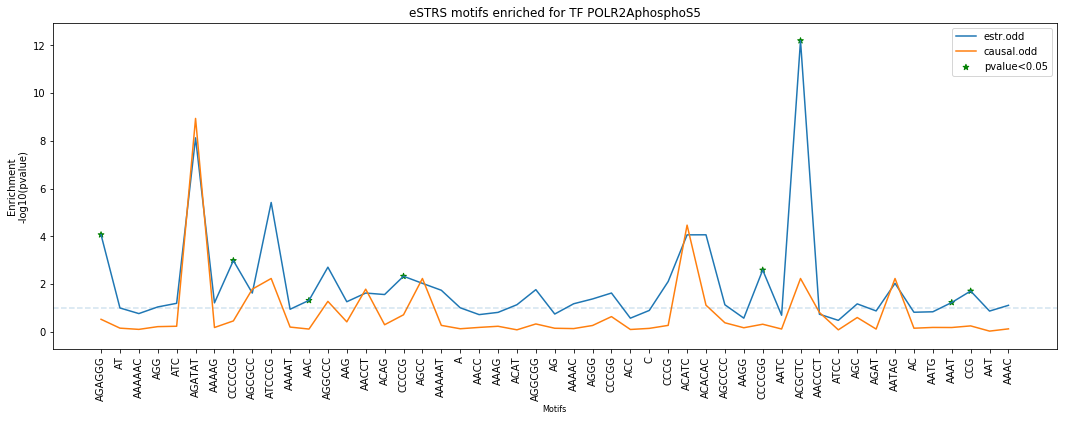

In [93]:
TF = 'POLR2AphosphoS5'                                           #####  Transcription factor of interest
transfacts = [x for x in os.listdir(TFs) if TF in x][0]  #
mytf = TFs+transfacts
polr2 = plotmotifenrichmentatTF(TF)

POLR2A
All STRs:  5113 	All TFs STRs:  5113 	All eSTRs:  482 	All Causal:  75


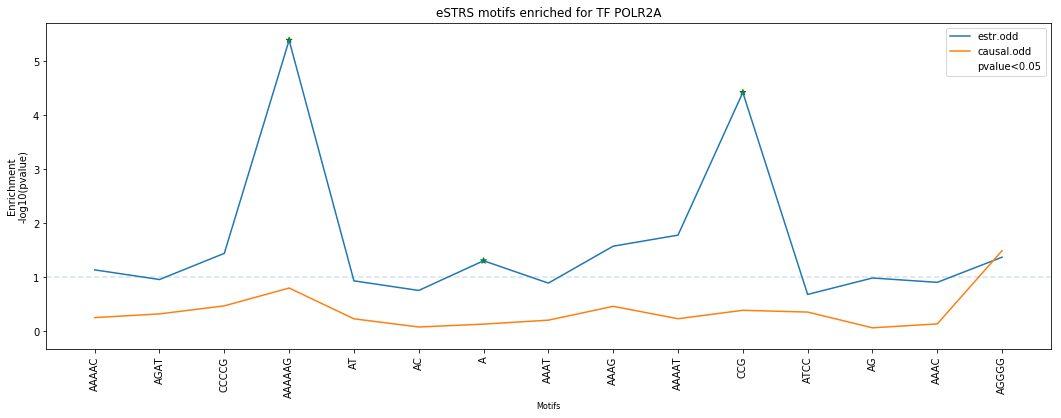

POLR2AphosphoS2
All STRs:  24619 	All TFs STRs:  24619 	All eSTRs:  2192 	All Causal:  405


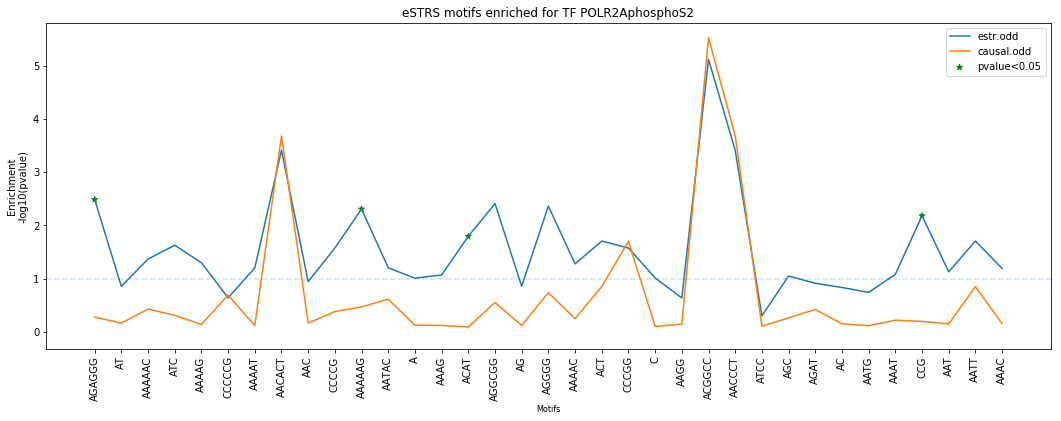

H3K79me2
All STRs:  22850 	All TFs STRs:  22850 	All eSTRs:  2623 	All Causal:  487


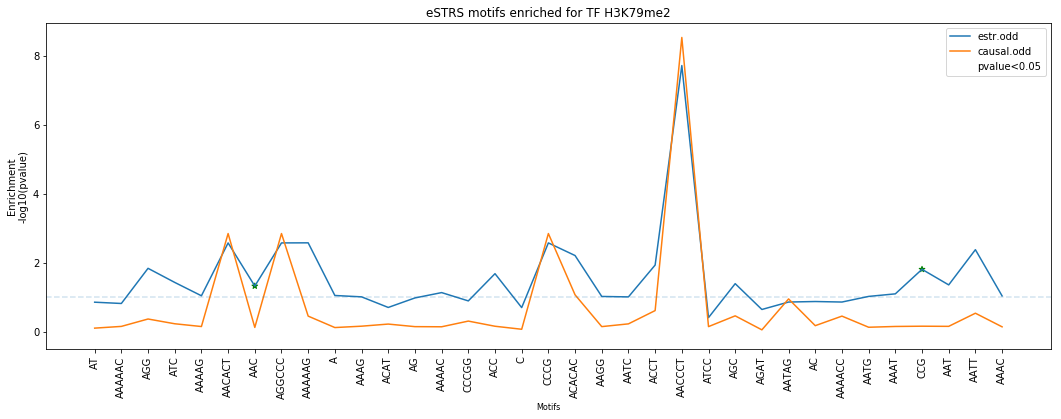

H3K4me3
All STRs:  8398 	All TFs STRs:  8398 	All eSTRs:  973 	All Causal:  195


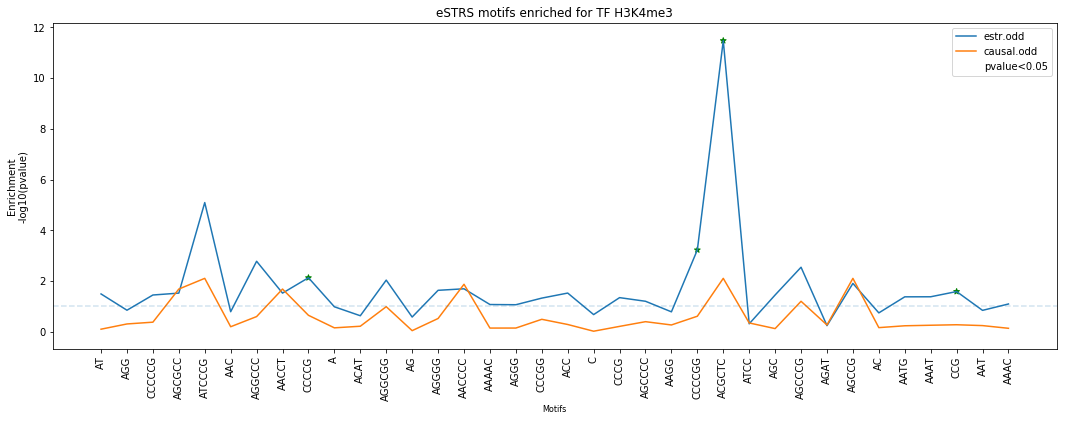

MLLT1
All STRs:  3534 	All TFs STRs:  3534 	All eSTRs:  288 	All Causal:  57


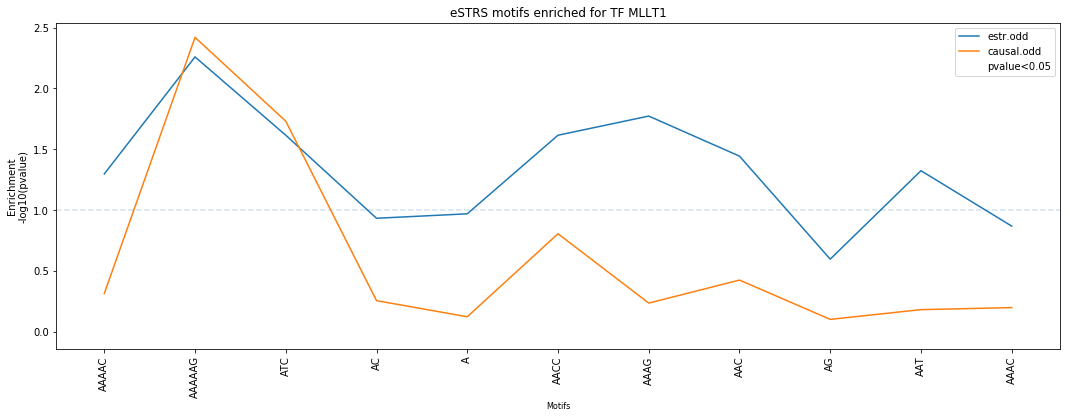

NRF1
All STRs:  9078 	All TFs STRs:  9078 	All eSTRs:  771 	All Causal:  127


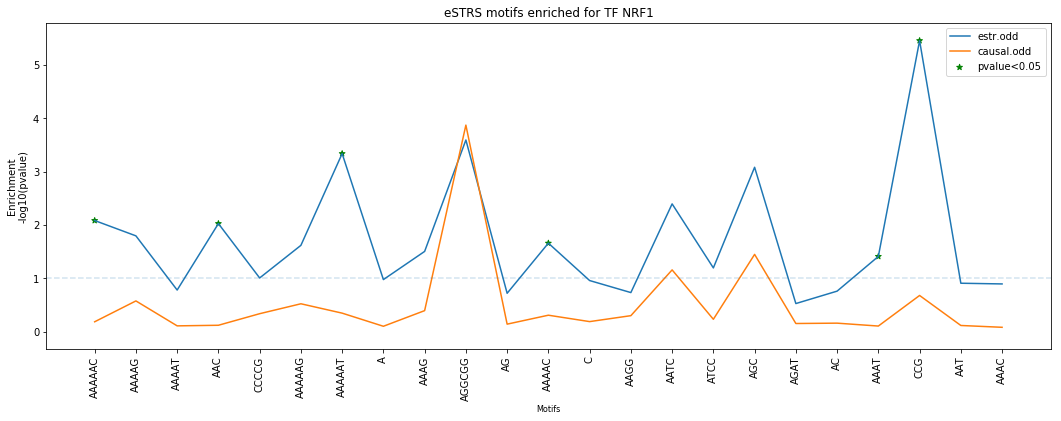

NR2F1
All STRs:  3031 	All TFs STRs:  3031 	All eSTRs:  244 	All Causal:  43


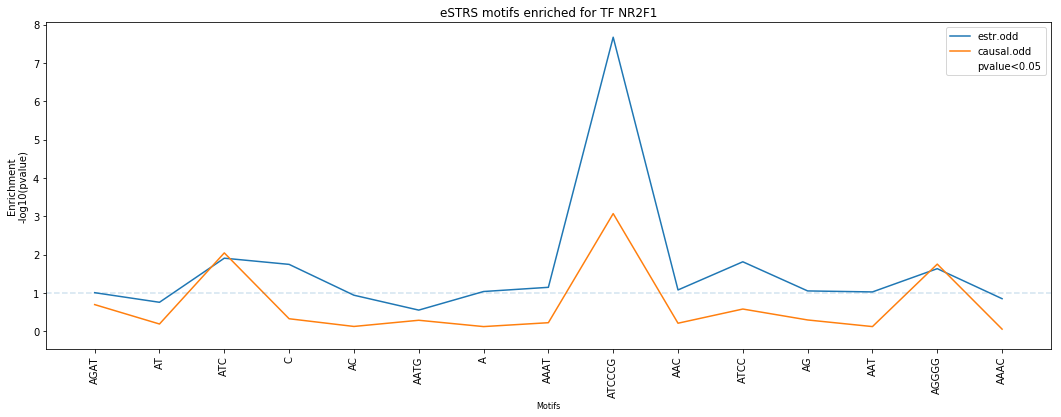

CHD1
All STRs:  813 	All TFs STRs:  813 	All eSTRs:  98 	All Causal:  18


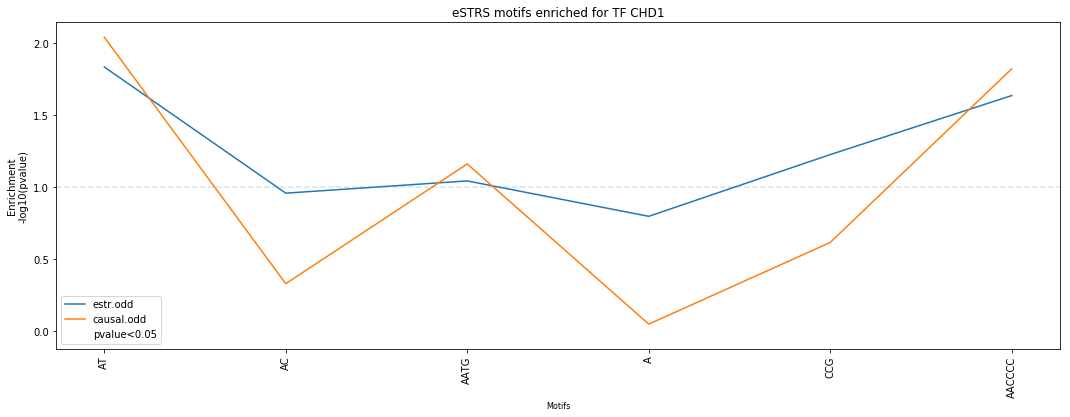

In [96]:
#
tfs = ['POLR2A','POLR2AphosphoS2','H3K79me2',"H3K4me3","MLLT1",'NRF1', 'NR2F1','CHD1']
for TF in tfs:
    data = plotmotifenrichmentatTF(TF)

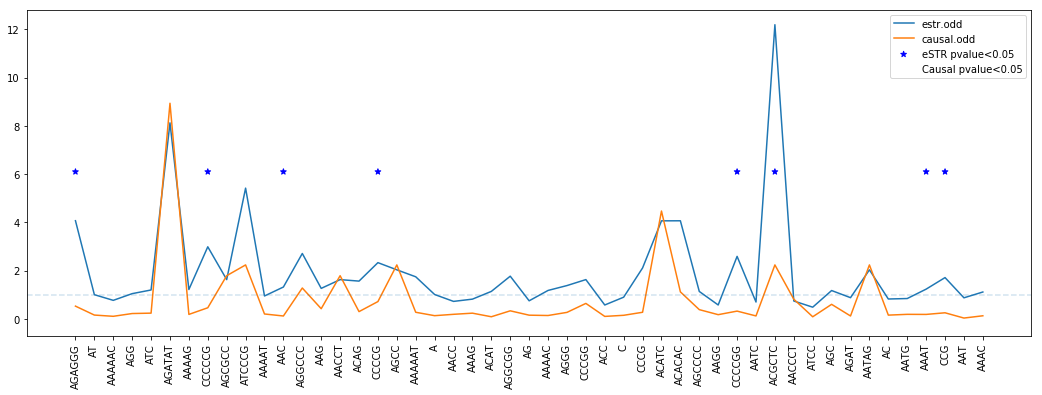

,estr.pval,causal.odd,estr.odd,causal.pval,dot1,dot2,dot,cdot
AGAGGG,2.000420,0.525430,4.067147,-0.000000,0,0,2,0
AT,-0.000000,0.154880,0.999932,13.493407,1,0,0,1
AAAAAC,0.405132,0.103308,0.765099,5.487336,1,0,0,1
AGG,0.094540,0.218240,1.042990,3.616551,1,0,1,1
ATC,0.233007,0.234630,1.195088,1.651885,1,0,1,1
AGATAT,0.683547,8.937541,8.124591,0.718555,0,1,1,1
AAAAG,0.284374,0.181811,1.214583,2.407745,1,0,1,1
CCCCCG,2.425431,0.457848,2.985302,0.364856,0,0,2,0
AGCGCC,0.299483,1.787247,1.624657,0.327068,0,1,1,1
ATCCCG,1.018134,2.234140,5.417730,0.385444,0,1,1,1


In [76]:
def test(G,n):
    #['estr.pval','causal.odd','estr.odd','causal.pval']
    val=0
    if G['causal.odd'].values[0]>1 :
        if G['causal.pval']>1.31:
            val=n
    if G['estr.odd']>1:
        if G['estr.odd']>1.31:
            val=n
    return(val)


df = polr2.loc[(polr2['estr.count']>0) & (polr2['causal.count']>0)][['estr.pval','causal.odd','estr.odd','causal.pval']]
ax = df[['estr.odd','causal.odd']].plot(figsize=(18,6)) 
ax.set_xticks(tick)
ax.set_xticklabels(df.index, rotation=90)
tick=[x for x in range(0,len(df.index), 1)]

M=max(df['estr.odd'])
df['dot1']=df['estr.pval'].apply(lambda x: 1 if  (x>=1.31)  else 0)
df['dot2']=df['estr.odd'].apply(lambda x: 1 if  (x>=1)  else 0)
df['dot']=df['dot1']+df['dot2']
col=list(df['dot'].apply(lambda x: 'white' if x<2 else 'b'))
ax.scatter(tick, list(df['dot']*(M/4)), color=col, marker='*', label='eSTR pvalue<0.05')

M=max(df['causal.odd'])
df['dot1']=df['causal.pval'].apply(lambda x: 1 if  (x>=1.31)  else 0)
df['dot2']=df['causal.odd'].apply(lambda x: 1 if  (x>=1)  else 0)
df['cdot']=df['dot1']+df['dot2']
col=list(df['cdot'].apply(lambda x: 'white' if x<2 else 'gold'))
ax.scatter(tick, list(df['cdot']*(M/4)), color=col, marker='*', label='Causal pvalue<0.05')


plt.axhline(y=1, xmin=0, xmax=1, hold=None, alpha=0.2, ls='--')
plt.legend()
plt.show()
df

GATAD2B
All STRs:  1580 	All TFs STRs:  1580 	All eSTRs:  446 	All Causal:  87


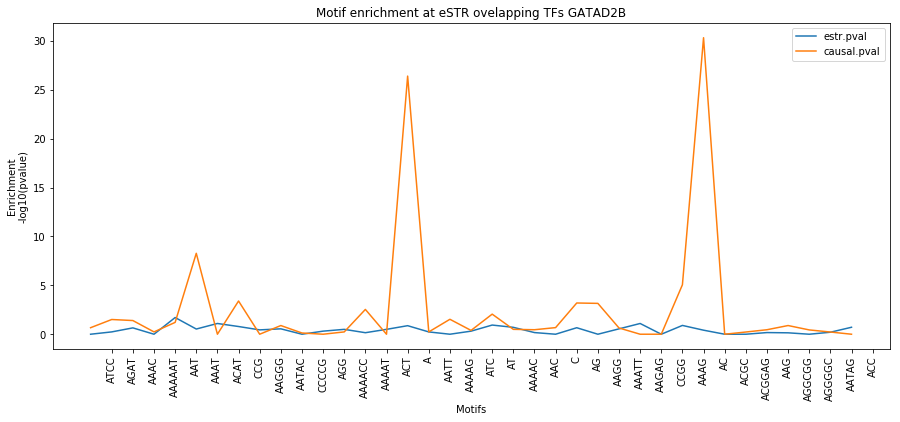

36


In [11]:
data = plotmotifenrichmentatTF('GATAD2B')
#Motif enrichment by tissue
#background = all STR at TF           foreground motif enriched at eSTR 
Mset,O,Mapdata,pdata = getfisher(data,TISSUES)
df1 = pd.DataFrame(pdata)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset

GATAD2B
All STRs:  2512 	All TFs STRs:  2512 	All eSTRs:  418 	All Causal:  103


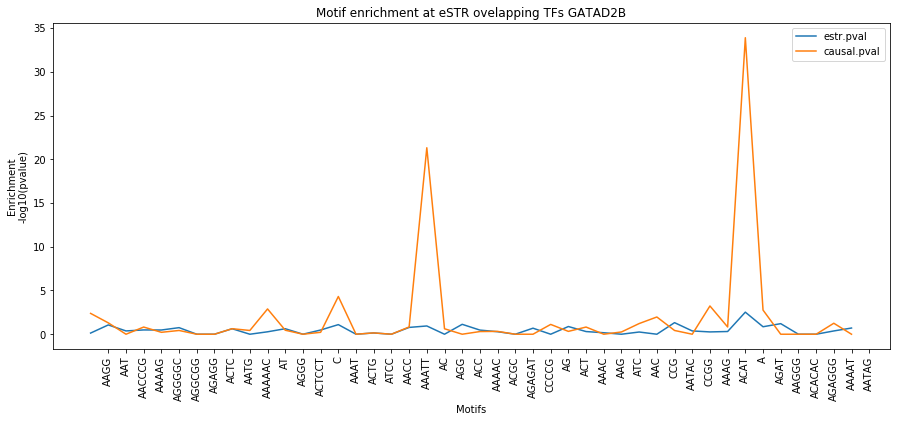

36


In [27]:
data = plotmotifenrichmentatTF('GATAD2B')
#Motif enrichment by tissue
#background = all STR at TF           foreground motif enriched at eSTR 
Mset,O,Mapdata,pdata = getfisher(data,TISSUES)
df1 = pd.DataFrame(pdata)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset